In [ ]:
!pip install yfinance
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install plotly
!pip install scikit-learn
!pip install tensorflow
!pip install keras
!pip install plotly

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import tensorflow as tf
import keras
import plotly.express as px

In [ ]:
def sharpe(daily_returns):
    mu = daily_returns.mean()
    sigma = daily_returns.std()
    return (mu / sigma) * np.sqrt(252)


In [ ]:
def backtest_portfolio(
    tickers,
    start_date,
    end_date,
    rebalance_freq="D",        # "D", "W-FRI", "ME", "YE", etc.
    initial_capital=100_000,
    trading_days_per_year=252
):
    """
    Share-based backtest:
      - Equally allocate capital into shares at each rebalance.
      - Between rebalances shares are held constant.
      - Final portfolio value and Sharpe ratio are computed.

    Returns:
      (port_values: pd.Series, final_value: float, sharpe: float)
    """
    # 1. Download prices
    prices = yf.download(tickers, start=start_date, end=end_date)["Close"].dropna()

    # 2. Rebalance dates
    if rebalance_freq == "D":
        rebalance_dates = prices.index
    else:
        rebalance_dates = prices.resample(rebalance_freq).last().index
    rebalance_dates = rebalance_dates.insert(0, prices.index[0])

    # 3. Initialize shares
    shares = pd.DataFrame(index=prices.index, columns=tickers, dtype=float)
    # Initial allocation
    init_prices = prices.iloc[0]
    alloc = initial_capital / len(tickers)
    current_shares = alloc / init_prices
    shares.iloc[0] = current_shares

    # 4. Simulate through time
    for date in prices.index[1:]:
        # carry forward shares
        shares.loc[date] = current_shares

        # if it's a rebalance date, reset allocations
        if date in rebalance_dates:
            port_value = (current_shares * prices.loc[date]).sum()
            alloc = port_value / len(tickers)
            current_shares = alloc / prices.loc[date]
            shares.loc[date] = current_shares

    # 5. Compute portfolio values
    port_values = (shares * prices).sum(axis=1)

    # 6. Metics
    daily_ret = port_values.pct_change().dropna()
    final_value = port_values.iloc[-1]
    total_return   = (final_value / initial_capital - 1) * 100
    annual_vol     = (daily_ret.std() * np.sqrt(trading_days_per_year)) * 100
    sharpe_ratio   = (daily_ret.mean() / daily_ret.std()) * np.sqrt(trading_days_per_year)

    # Compute duration in years
    days_held = (port_values.index[-1] - port_values.index[0]).days
    years_held = days_held / 365.25

    # Compute annualized return (CAGR)
    annual_return = ((final_value / initial_capital) ** (1 / years_held) - 1) * 100


    # 7. Plot Portfolio Value over Time
    df_plot = port_values.reset_index().rename(columns={"index": "Date", 0: "Portfolio Value"})
    fig = px.line(
        df_plot,
        x="Date",
        y=port_values.name if port_values.name else "Portfolio Value",
        title=f"Portfolio Value (Rebalance={rebalance_freq})",
        labels={"value": "Value (USD)", "Date": "Date"}
    )
    fig.update_layout(hovermode="x unified")
    fig.show()


    #8. Plot Daily Returns
    mean_ret = daily_ret.mean()
    std_ret = daily_ret.std()

    # Define 2-sigma thresholds
    lower_bound = mean_ret - 2 * std_ret
    upper_bound = mean_ret + 2 * std_ret

    # Separate into normal and extreme returns
    normal_ret = daily_ret[(daily_ret >= lower_bound) & (daily_ret <= upper_bound)]
    extreme_ret = daily_ret[(daily_ret < lower_bound) | (daily_ret > upper_bound)]

    # Plot
    plt.figure(figsize=(10, 5))

    # Plot normal returns in blue
    plt.hist(normal_ret, bins=100, alpha=0.7, color='cornflowerblue', edgecolor='black', label='Within ±2σ')

    # Overlay extreme returns in red
    plt.hist(extreme_ret, bins=100, alpha=0.7, color='red', edgecolor='black', label='> ±2σ')

    # Mark mean and ±2σ thresholds
    plt.axvline(mean_ret, color='black', linestyle='-', label='Mean')
    plt.axvline(upper_bound, color='green', linestyle='--', label='+2σ')
    plt.axvline(lower_bound, color='green', linestyle='--', label='-2σ')

    plt.title(f"Daily Returns (Rebalance={rebalance_freq})")
    plt.xlabel("Daily Return")
    plt.xticks(np.arange(-0.1, 0.1, 0.02))
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()


    print(f"Final portfolio value: ${final_value:,.2f}")
    print(f"Total Return:  {total_return:.2f}%")
    print(f"Annual Return:  {annual_return:.2f}%")
    print(f"Volatility : {annual_vol:.2f}%")
    print(f"Annualized Sharpe ratio: {sharpe_ratio:.2f}")

    return port_values, final_value, sharpe

## War is Coming Portfolio
This portfolio invests in a broad-range of defense companies, diversified regionally.

In [ ]:
start_date = "2010-01-01"
end_date = "2015-01-01"
# end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

portfolio_value = 100000

# tickers = ['LMT', 'NOC', 'GD', 'RTX', 'BAESY', 'PLTR', 'KTOS', 'MRCY', 'ESLT', 'RNMBY', 'FINMY']
tickers = ['BAESY','RNMBY',]

# Monthly Rebalancing (ME)
portfolio_values, final_value, sharpe = backtest_portfolio(tickers, start_date, end_date, rebalance_freq="ME", initial_capital=portfolio_value)



[*********************100%***********************]  2 of 2 completed


Final portfolio value: $136,012.55
Total Return:  36.01%
Volatility : 21.66%
Annualized Sharpe ratio: 0.79


In [ ]:
start_date = "2022-01-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

portfolio_value = 100000

tickers = ['NTR', 'CF', 'MOS', 'YARIY', 'ICL', 'OCINF', 'LXU', 'UAN', 'PBR']

# Monthly Rebalancing (ME)
portfolio_values, final_value, sharpe = backtest_portfolio(tickers, start_date, end_date, rebalance_freq="ME", initial_capital=portfolio_value)



[*********************100%***********************]  9 of 9 completed


Final portfolio value: $116,780.65
Return:  16.78%
Volatility : 38.59%
Annualized Sharpe ratio: -0.16


#Obesity & Insulin

[*********************100%***********************]  3 of 3 completed


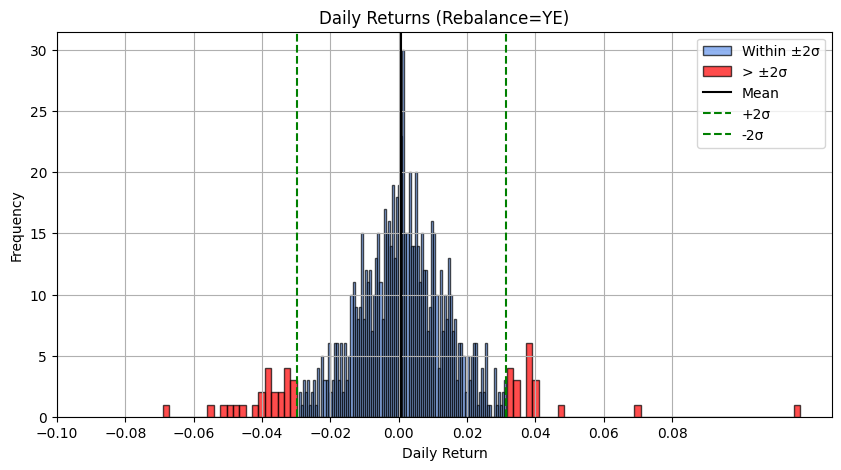

Final portfolio value: $181,801.43
Total Return:  81.80%
Volatility : 24.35%
Annualized Sharpe ratio: 0.85


In [ ]:
start_date = "2022-01-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

portfolio_value = 100000

# tickers = ['NVO', 'LLY', 'SNY', 'AZN']
tickers = ['NVO', 'LLY', 'AZN']

# Monthly Rebalancing (ME)
portfolio_values, final_value, sharpe = backtest_portfolio(tickers, start_date, end_date, rebalance_freq="YE", initial_capital=portfolio_value)



## Quantum Computing

In [ ]:
start_date = "2025-01-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

portfolio_value = 100000

tickers = ['IONQ', 'RGTI', 'QBTS', 'QUBT']
# tickers = ['IONQ', 'RGTI']

# Monthly Rebalancing (ME)
portfolio_values, final_value, sharpe = backtest_portfolio(tickers, start_date, end_date, rebalance_freq="ME", initial_capital=portfolio_value)



[*********************100%***********************]  4 of 4 completed


Final portfolio value: $108,588.40
Total Return:  8.59%
Volatility : 158.57%
Annualized Sharpe ratio: 0.73


#Inflation is gonna stay

In [ ]:
start_date = "2024-01-01"
end_date = "2025-01-01"
# end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

portfolio_value = 100000

tickers = ['GLD', 'VOO']

# Monthly Rebalancing (ME)
portfolio_values, final_value, sharpe = backtest_portfolio(tickers, start_date, end_date, rebalance_freq="YE", initial_capital=portfolio_value)



[*********************100%***********************]  2 of 2 completed


Final portfolio value: $126,367.59
Total Return:  26.37%
Volatility : 11.02%
Annualized Sharpe ratio: 2.19


#EUR/USD going up

In [ ]:
start_date = "2025-01-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

portfolio_value = 100000

tickers = ['EURUSD=X']

# Monthly Rebalancing (ME)
portfolio_values, final_value, sharpe = backtest_portfolio(tickers, start_date, end_date, rebalance_freq="YE", initial_capital=portfolio_value)



[*********************100%***********************]  1 of 1 completed


Final portfolio value: $110,013.89
Total Return:  10.01%
Volatility : 9.89%
Annualized Sharpe ratio: 2.46


# Stock Calendar Spread

[*********************100%***********************]  1 of 1 completed


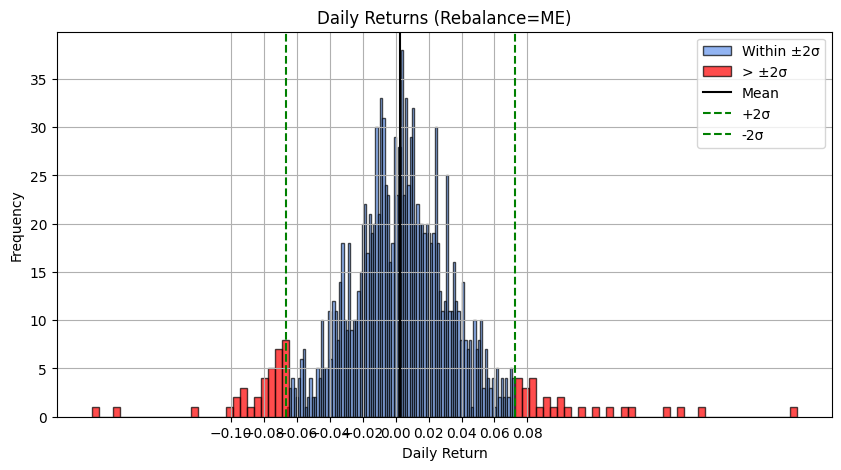

Final portfolio value: $2,262,664.85
Total Return:  2162.66%
Annual Return:  78.04%
Volatility : 55.03%
Annualized Sharpe ratio: 1.33


In [ ]:
# start_date = "2020-01-01"
start_date = "2020-01-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

portfolio_value = 100000

tickers = ['NVDA']

# Monthly Rebalancing (ME)
portfolio_values, final_value, sharpe = backtest_portfolio(tickers, start_date, end_date, rebalance_freq="ME", initial_capital=portfolio_value)